In [2]:
import os
os.chdir('/home/zola/Projects/temp/KBQA/src')
from setup import IndexSearch, Mongo_Connector

e_index = IndexSearch('dbpedia201604e')
p_index = IndexSearch('dbpedia201604p')

import json
from collections import Counter

### LC-QUAD

In [3]:
mongo = Mongo_Connector('kbqa', 'lcquad')

# load LC-QUAD dataset
loaded = True

import os
os.chdir("/home/zola/Projects/temp/KBQA/data/lcquad")
import pprint
lcquad_path = "lcquad_answers.json"
if not loaded:
    mongo.load_json(lcquad_path)
mongo.count_all_docs()
doc = mongo.get_sample(limit=1)[0]
pprint.pprint(doc)

4998 docs
{'1hop': [['http://dbpedia.org/resource/Bill_Finger',
           'http://dbpedia.org/ontology/ComicsCharacter'],
          ['http://dbpedia.org/ontology/creator',
           'http://www.w3.org/1999/02/22-rdf-syntax-ns#type']],
 '1hop_ids': [[5516345, 2979916], [362, 68655]],
 '1hop_spans': [['bill finger', 'comic characters'], ['painted by']],
 '2hop': [[], []],
 '2hop_ids': [[], []],
 '2hop_spans': [[], []],
 'SerialNumber': '1',
 '_id': ObjectId('5c3501d00666955066857ae2'),
 'answers': ['http://dbpedia.org/resource/Batman',
             'http://dbpedia.org/resource/Alfred_Pennyworth',
             'http://dbpedia.org/resource/Apache_Chief',
             'http://dbpedia.org/resource/James_Gordon_(comics)',
             'http://dbpedia.org/resource/Hugo_Strange',
             'http://dbpedia.org/resource/Wildcat_(comics)',
             'http://dbpedia.org/resource/Bat-Mite',
             'http://dbpedia.org/resource/Vicki_Vale',
             'http://dbpedia.org/resource/Squir

In [10]:
# define random test/train splits
loaded = True
limit = None

if not loaded:
    test_size = 0.2
    with open(lcquad_path, "r") as json_file:
        docs = json.load(json_file)
        X, question_types = [], []
        for doc in docs:
            X.append(doc['SerialNumber'])
            question_types.append(doc['question_type'])
        print("%d docs loaded"%len(docs))

    from sklearn.model_selection import train_test_split
    # fix random seed
    X_train, X_test = train_test_split(X, test_size=test_size,
                                       stratify=question_types, random_state=103232)
    print("%d train samples and %d test samples" % (len(X_train), len(X_test)))

    # annotate
    samples = mongo.get_sample(limit=limit)
    for doc in samples:
        if doc['SerialNumber'] in X_train:
            doc['train'] = True
        else:
            doc['train'] = False
        mongo.col.update_one({'_id': doc['_id']}, {"$set": doc}, upsert=True)

sample = mongo.get_sample(limit=1)[100]
print(sample['train'])

True


In [20]:
# reproduce the original lcquad test/train splits
loaded = True

limit = None
lcquad_train_path = 'train-data.json'  # wget https://raw.githubusercontent.com/AskNowQA/LC-QuAD/data/train-data.json

if not loaded:
    X_train = []
   
    with open(lcquad_train_path, "r") as json_file:
        docs = json.load(json_file)
        for doc in docs:
            X_train.append(str(int(doc['_id']) + 1))
        print("%d docs loaded"%len(docs))

    print("%d train samples" % (len(X_train)))
    # annotate
    samples = mongo.get_sample(train=False, limit=limit)
    for doc in samples:
        if doc['SerialNumber'] in X_train:
            doc['train'] = True
        else:
            doc['train'] = False
        mongo.col.update_one({'_id': doc['_id']}, {"$set": doc}, upsert=True)

sample = mongo.get_sample(limit=1)[100]
print(sample['train'])

True


In [8]:
# annotate GS entities and predicates across hops
# parse entities and predicates annotations across hops from the SQL query and update MongoDB collection
loaded = False

verbose = False
limit = None

if not loaded:
    samples = mongo.get_sample(train=False, limit=limit)
    count = 0
    for doc in samples:
        # fix URI !
        sparql_query = doc['sparql_query']
        # parse the SPARQL query into spo triples
        tripples = sparql_query[sparql_query.find("{")+1:sparql_query.find("}")].split('. ')

        # collect entities and predicates separately for 2 hops
        correct_intermediate_predicates = []
        correct_intermediate_entities = []
        correct_question_predicates = []
        correct_question_entities = []

        for tripple in tripples:
            if tripple:
                entities = []
                s, p, o = tripple.strip().split()
                if s[0] != '?':
                    entities.append(s[1:-1])
                if o[0] != '?':
                    entities.append(o[1:-1])
                p = p[1:-1]

                if '?uri' not in tripple:
                    correct_intermediate_predicates.append(p)
                    correct_intermediate_entities.extend(entities)
                else:
                    correct_question_predicates.append(p)
                    correct_question_entities.extend(entities)
        if verbose:
            print('\n')
            print(sparql_query)
            print(correct_intermediate_entities, correct_intermediate_predicates)
            print(correct_question_entities, correct_question_predicates)

        # update question annotations save in MongoDB
        if not correct_intermediate_predicates:
            # 1 hop
            doc['1hop'] = [correct_question_entities, correct_question_predicates]
            doc['2hop'] = [[], []]
        else:
            # 2 hops
            doc['1hop'] = [correct_intermediate_entities, correct_intermediate_predicates]
            doc['2hop'] = [correct_question_entities, correct_question_predicates]
        
        doc['entity_uris'] = list(set(correct_question_entities+correct_intermediate_entities))
        # store all predicate URIs for subgraph extraction
        doc['predicate_uris'] = list(set(correct_question_predicates+correct_intermediate_predicates))
        
        mongo.col.update_one({'_id': doc['_id']}, {"$set": doc}, upsert=True)
        count +=1

    print("%d documents annotated with entities and predicates URIs across hops"%count)

# show sample annotation
sample = mongo.get_by_id("3")
print(sample['1hop'])
print(sample['2hop'])
print(sample['entity_uris'])
print(sample['predicate_uris'])

1000 documents annotated with entities and predicates URIs across hops
[['http://dbpedia.org/resource/Gestapo'], ['http://dbpedia.org/ontology/parentOrganisation']]
[[], ['http://dbpedia.org/ontology/leader']]
['http://dbpedia.org/resource/Gestapo']
['http://dbpedia.org/ontology/leader', 'http://dbpedia.org/ontology/parentOrganisation']


In [14]:
# define random test/train split
loaded = True
limit = None

if not loaded:
    test_size = 0.2
    with open(lcquad_path, "r") as json_file:
        docs = json.load(json_file)
        X, question_types = [], []
        for doc in docs:
            X.append(doc['SerialNumber'])
            question_types.append(doc['question_type'])
        print("%d docs loaded"%len(docs))

    from sklearn.model_selection import train_test_split
    # fix random seed
    X_train, X_test = train_test_split(X, test_size=test_size,
                                       stratify=question_types, random_state=103232)
    print("%d train samples and %d test samples" % (len(X_train), len(X_test)))

    # annotate
    samples = mongo.get_sample(limit=limit)
    for doc in samples:
        if doc['SerialNumber'] in X_train:
            doc['train'] = True
        else:
            doc['train'] = False
        mongo.col.update_one({'_id': doc['_id']}, {"$set": doc}, upsert=True)

sample = mongo.get_sample(limit=1)[100]
print(sample['train'])

True


In [9]:
# store HDT IDs across hops
limit = None

def annotate_hop_ids(hop):
    samples = mongo.get_sample(train=False, limit=limit)
    count = 0
    for doc in samples:
        e, p = doc[hop]
        e_ids = []
        for uri in e:
            try:
                e_ids.append(e_index.look_up_by_uri(uri)[0]['_source']['id'])
            except:
                print("%s not found in the entity catalog"%uri)

        p_ids = []
        for uri in p:
            try:
                p_ids.append(p_index.look_up_by_uri(uri)[0]['_source']['id'])
            except:
                print("%s not found in the predicate catalog"%uri)
        
        doc[hop+'_ids'] = e_ids, p_ids
            
        # update doc in MongoDB
        mongo.col.update_one({'_id': doc['_id']}, {"$set": doc}, upsert=True)
        count += 1
        
    print("%d documents annotated with ids"%count)


annotate_hop_ids('1hop')
annotate_hop_ids('2hop')

# show sample annotations
sample = mongo.get_sample(limit=1)[0]
print(sample['1hop_ids'])
print(sample['2hop_ids'])

1000 documents annotated with ids
1000 documents annotated with ids
[[20271581, 24029645], [1076]]
[[], []]


In [10]:
# store HDT IDs for questions and answers URIs
loaded = False
limit = None

if not loaded:
    samples = mongo.get_sample(train=False, limit=limit)
    count = 0
    for doc in samples:
        # get all correct entity and predicate from the GS annotations
        e_ids = []
        for uri in doc['entity_uris']:
            try:
                e_ids.append(e_index.look_up_by_uri(uri)[0]['_source']['id'])
            except:
                print("%s not found in the entity catalog"%uri)
        doc['entity_ids'] = e_ids

        p_ids = []
        for uri in doc['predicate_uris']:
            try:
                p_ids.append(p_index.look_up_by_uri(uri)[0]['_source']['id'])
            except:
                print("%s not found in the predicate catalog"%uri)
        
        doc['predicate_ids'] = p_ids
        
        if 'answers' in doc:
            a_ids = []
            for uri in doc['answers']:
                try:
                    a_ids.append(e_index.look_up_by_uri(uri)[0]['_source']['id'])
                except:
                    print("%s not found in the entity catalog"%uri)

            doc['answers_ids'] = a_ids
            
        # update doc in MongoDB
        mongo.col.update_one({'_id': doc['_id']}, {"$set": doc}, upsert=True)
        count += 1
        
    print("%d documents annotated with ids"%count)

# show sample annotations
sample = mongo.get_sample(limit=1)[0]
print(sample['entity_ids'])
print(sample['predicate_ids'])
if 'answers' in sample:
    print(sample['answers_ids'])

1000 documents annotated with ids
[24029645, 20271581]
[1076]


In [21]:
# dataset stats
predicate_ids
# number of documents with 2 hops
print("%d complex questions (with more than one variable)"%mongo.col.find({"2hop": { "$ne": [[], []] }}).count())
print("%d complex questions (with more than one variable)"%mongo.col.find({"train": True, "2hop": { "$ne": [[], []] }}).count())
print("%d complex questions (with more than one variable)"%mongo.col.find({"train": False, "2hop": { "$ne": [[], []] }}).count())

1982 complex questions (with more than one variable)
1599 complex questions (with more than one variable)
383 complex questions (with more than one variable)


/home/zola/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  after removing the cwd from sys.path.
/home/zola/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """
/home/zola/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  


In [6]:
# number of documents with >1 triple
limit = None
samples = mongo.get_sample(train=True, limit=limit)
counter = 0
for doc in samples:
    n_components = len(doc['predicate_ids']) + len(doc['entity_ids'])
    if n_components > 2:
        counter += 1
print(counter)

3131


In [24]:
# question lengths distribution
limit = None
from keras.preprocessing.text import text_to_word_sequence
import numpy as np
samples = mongo.get_sample(train=False, limit=limit)
n_words_distr = []
for doc in samples:
    words = text_to_word_sequence(doc['question'])
    # add the sample to the dataset 
    n_words_distr.append(len(words))

# show basic stats
min_len = min(n_words_distr)
mean_len = np.mean(n_words_distr)
max_len = max(n_words_distr)
print("Min:%d Avg:%d Max:%d"%(min_len, mean_len, max_len))

Min:3 Avg:11 Max:22


In [25]:
# question number of question URIs distribution (predicate + entity)
from keras.preprocessing.text import text_to_word_sequence
import numpy as np
samples = mongo.get_sample(train=False, limit=limit)
n_distr = []
for doc in samples:
    n_distr.append(len(doc['entity_uris']+doc['predicate_uris']))

# show basic stats
min_len = min(n_distr)
mean_len = np.mean(n_distr)
max_len = max(n_distr)
print("Min:%d Avg:%d Max:%d"%(min_len, mean_len, max_len))

Min:2 Avg:3 Max:6


In [14]:
# number of answers per question
import numpy as np

samples = mongo.get_sample(train=False, limit=None)
n_distr = []
for doc in samples:
    n_distr.append(len(doc['answers']) if 'answers' in doc else 1)

# show basic stats
min_len = min(n_distr)
mean_len = np.median(n_distr)
max_len = max(n_distr)
print("Min:%d Median:%d Max:%d"%(min_len, mean_len, max_len))
p_distribution = Counter(n_distr)

Min:1 Median:1 Max:8195


In [10]:
# number of unique predicates and distribution 
limit = None

# training set
samples = mongo.get_sample(train=True, limit=limit)
predicates = []
for doc in samples:
    predicates.extend(doc['predicate_uris'])

# test set
# samples = mongo.get_sample(train=False, limit=limit)
# for doc in samples:
#     predicates.extend(doc['predicate_uris'])    


p_distribution = Counter([p for p in predicates if p != 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'])
# most common
print (p_distribution.most_common(30))

predicates = list(set(predicates))
print("%d predicates"%len(predicates))

[('http://dbpedia.org/ontology/religion', 64), ('http://dbpedia.org/ontology/award', 64), ('http://dbpedia.org/ontology/birthPlace', 52), ('http://dbpedia.org/property/awards', 50), ('http://dbpedia.org/ontology/deathPlace', 44), ('http://dbpedia.org/ontology/team', 44), ('http://dbpedia.org/ontology/country', 42), ('http://dbpedia.org/ontology/sport', 42), ('http://dbpedia.org/ontology/almaMater', 41), ('http://dbpedia.org/property/owner', 41), ('http://dbpedia.org/ontology/manufacturer', 41), ('http://dbpedia.org/property/placeOfBirth', 40), ('http://dbpedia.org/ontology/location', 39), ('http://dbpedia.org/ontology/occupation', 38), ('http://dbpedia.org/property/writer', 35), ('http://dbpedia.org/property/distributor', 35), ('http://dbpedia.org/property/birthPlace', 34), ('http://dbpedia.org/ontology/author', 34), ('http://dbpedia.org/ontology/knownFor', 34), ('http://dbpedia.org/ontology/producer', 33), ('http://dbpedia.org/ontology/formerTeam', 33), ('http://dbpedia.org/property/h

* 5 predicates not seen during training
* most frequent predicate: type ('http://www.w3.org/1999/02/22-rdf-syntax-ns#type', 1568)

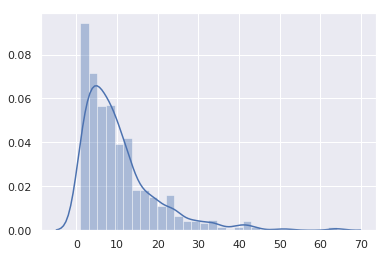

In [11]:
import matplotlib.pyplot as plt

def plot_distribution(counter):
    '''
    Plot the distribution stored in the counter object
    '''
    # prepare data
    import numpy as np
    labels, values = zip(*counter.items())
    indexes = np.arange(len(labels))

    # generate a plot
    import seaborn as sns
    sns.set(color_codes=True)
    sns.distplot(values)
    plt.show()

plot_distribution(p_distribution)

In [23]:
# write questions into file to generate embeddings
samples = mongo.get_sample(train=True, limit=limit)
os.chdir("/home/zola/Projects/temp/KBQA/data/lcquad")
with open('questions.txt', 'w') as fout:
    for doc in samples:
        fout.write(doc['question']+'\n')

In [4]:
# annotate types separately
loaded = True

verbose = False
limit = None

if not loaded:
    samples = mongo.get_sample(train=False, limit=limit)
    count = 0
    for doc in samples:
        # fix URI !
        sparql_query = doc['sparql_query']
        # parse the SPARQL query into spo triples
        tripples = sparql_query[sparql_query.find("{")+1:sparql_query.find("}")].split('. ')

        # collect entities and predicates separately for 2 hops
        classes = []
        cids = []
        for tripple in tripples:
            if tripple:
                entities = []
                s, p, o = tripple.strip().split()
#                     
                p = p[1:-1]
                if p == 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type':
                    if o[0] != '?':
                        uri = o[1:-1]
                        classes.append(uri)
                        try:
                            cids.append(e_index.look_up_by_uri(uri)[0]['_source']['id'])
                        except:
                            print("%s not found in the entity catalog"%uri)
               
        if classes and verbose:
            print(sparql_query)
            print(classes)
            print(cids)
       
        doc['classes'] = classes
        doc['classes_ids'] = cids

        mongo.col.update_one({'_id': doc['_id']}, {"$set": doc}, upsert=True)
        count +=1

    print("%d documents annotated with entities and predicates URIs across hops"%count)

# show sample annotation
sample = mongo.get_by_id("2652")
print(sample['sparql_query'])
print(sample['classes'])
print(sample['classes_ids'])

999 documents annotated with entities and predicates URIs across hops
SELECT DISTINCT ?uri WHERE {?uri <http://dbpedia.org/property/music> <http://dbpedia.org/resource/Akira_Ifukube>  . ?uri <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://dbpedia.org/ontology/Film>}
['http://dbpedia.org/ontology/Film']
[2979987]


## QALD

In [57]:
mongo = Mongo_Connector('kbqa', 'qald')

ENDPOINT = 'http://wikidata.communidata.at/dbpedia/query'

# load LC-QUAD dataset
loaded = True

if not loaded:
    import os
    os.chdir("/home/zola/Projects/temp/KBQA/data/qald")

    import json
    import pprint
    data_path = "qald-7-train-multilingual.json"
    with open(data_path) as f:
        dataset = json.load(f)
        for q in dataset['questions']:
            doc = {}
            doc['SerialNumber'] = q['id']
            doc['question'] = q['question'][0]['string']
            doc['sparql_query'] = q['query']['sparql'].replace('\n', ' ')
            response = requests.get(ENDPOINT, params={'query': doc['sparql_query'], 'output': 'json'}).json()
            if 'results' in response:
                results = response['results']['bindings']
                doc['answers'] = [v['value'] for r in results for v in r.values()]
            elif 'boolean' in response:
                doc['bool_answer'] = response['boolean']
            doc['train'] = False
            mongo.col.insert_one(doc)
        
mongo.count_all_docs()
doc = mongo.get_sample(train=False, limit=1)[0]
pprint.pprint(doc)
print(doc['sparql_query'])

215 docs
{'SerialNumber': '0',
 '_id': ObjectId('5c5dddac06669524ac939efa'),
 'answers': ['1863-07-03'],
 'question': 'When was the Battle of Gettysburg?',
 'sparql_query': 'PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX res: '
                 '<http://dbpedia.org/resource/> SELECT DISTINCT ?date  WHERE '
                 '{         res:Battle_of_Gettysburg dbo:date ?date . }',
 'train': False}
PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX res: <http://dbpedia.org/resource/> SELECT DISTINCT ?date  WHERE {         res:Battle_of_Gettysburg dbo:date ?date . }


In [59]:
# parse the SPARQL query into spo triples
cursor = mongo.get_sample(train=False, limit=1)
with cursor:
    for doc in cursor:
        sparql_query = doc['sparql_query']
        print(sparql_query)
        tripples = sparql_query[sparql_query.find("{")+1:sparql_query.find("}")].split('. ')

        # collect entities and predicates
        for tripple in tripples:
            if tripple:
                entities, predicates = [], []
                clause = tripple.strip().split()
                if clause[0] != 'filter':
                    s, p, o = clause
                    if s[0] != '?':
                        entities.append(s)
                    if o[0] != '?':
                        entities.append(o)
                    predicates.append(p)
                print(entities)
                print(predicates)

PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX res: <http://dbpedia.org/resource/> SELECT DISTINCT ?date  WHERE {         res:Battle_of_Gettysburg dbo:date ?date . }
['res:Battle_of_Gettysburg']
['dbo:date']
